# TP Final: Análisis del grafo de restaurants de Guía Óleo

## Alumnos: Alan Matys, Barbara Loccoco, Matias Peirano

In [2]:
import pickle
import os
import networkx as nx
from networkx.algorithms import bipartite
from node2vec import Node2Vec
import gensim
import matplotlib.pyplot as plt
import community

c:\Users\Alan\.conda\envs\network\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Consigna

- En este taller se estudiará el grafo proyectado de restaurants que surge a partir de las reseñas que los usuarios de Guía Óleo hacen en el sistema. El objetivo es entender si a partir de las reseñas que realiza cada usuario podemos encontrar un grafo que nos recomiende restaurants a partir de las similitud con un restaurant de referencia

- A continuación se entrega un código que carga y crea el grafo

### Construccion de la Red de Restaurantes

La red sera creada de la siguiente manera:
- Utilizando comentarios de usuarios sobre restaurantes creamos una red bipartita no dirigida, la cual cuenta con las siguientes entidades:

    - **Usuarios Comentadores:** Cada usuario que concurrio al restaurant y dejo una reseña al respecto de su experiencia en el restaurant, en donde un Usuario va a tener una relacion con todos los restaurantes que visitó.
    
    - **Restaurantes:** Cada restaurant que fue visitado por un Usuario Comentador, un restaurant puede haber recibido varios usuarios comentadores o 1 solo.

- En base a esta red, creamos un **grafo proyectado de Restaurantes**, en donde las relaciones entre restaurantes esta dado por la cantidad de nodos Usuarios comentadores que coinciden.


A continuación se entrega un código que carga y crea el grafo

## Código para cargar el grafo

In [3]:
with open(os.path.join('data','comments_list.p'), "rb") as f:
    comments_list = pickle.load(f)

print('Ejemplo de comentario 1:',comments_list[0])
print('Ejemplo de comentario 2:',comments_list[1])

# Creo el grafo que eventualmente será bipartito
G = nx.Graph()

users_nodes = set([])
restaurants_nodes = set([])
user_rest_edges = set([])

for c in comments_list:
    if c["user_num"] not in users_nodes:
        users_nodes.add(c["user_num"])
    if c["rest_url"] not in restaurants_nodes:
        restaurants_nodes.add((c["rest_url"], c["rest_name"]))
    user_rest_edges.add((c["user_num"], c["rest_url"]))

print('La cantidad de Nodos Restaurantes:',len(restaurants_nodes))
print('La cantidad de Nodos Usuarios Comentadores:',len(users_nodes))

# Agrego la lista de nodos y enlaces al grafo
G.add_nodes_from(users_nodes, bipartite=0)
G.add_nodes_from([(e[0], {"res_name": e[1]}) for e in restaurants_nodes], bipartite=1)
G.add_edges_from(set(user_rest_edges))

# Creo el grafo proyectado
restaurants = [e for e in G.nodes if G.nodes[e]["bipartite"] == 1]
projectionG = bipartite.weighted_projected_graph(G, restaurants)

print('La cantidad de nodos red proyectada:',len(projectionG.nodes))

Ejemplo de comentario 1: {'user_num': "b'[\\xe8\\x99,\\x86<J\\xfd\\x88\\xf5\\x8dS[\\xdeE\\xca'", 'rest_name': 'Pertutti', 'rest_url': '/restaurantes/Pertutti-11248', 'comments': 'La verdad, coincido con la mayoría de los comentarios. Fui hoy al mediodía para comer algo rápido, esquivando la cantidad de gente que había en el shopping de enfrente. Pedí un filet a la romana con puré de papas, mi mujer unos spaghetti del menú light y el nene ñoquis del menú infantil. Mi puré y lo de mi esposa no tenía gusto NADA. La atención, mala. El mozo nos volcó un vaso y nos tiró un trapo sucio que pasó así no más y se fue. Lo único respetable fue la panera y el helado del postre infantil. Y caro. No volveré.'}
Ejemplo de comentario 2: {'user_num': "b'[\\xe8\\x99,\\x86<J\\xfd\\x88\\xf5\\x8dS[\\xdeE\\xca'", 'rest_name': 'Justo! Brandzen', 'rest_url': '/restaurantes/Justo-Brandzen-9216', 'comments': 'Lindo lugar, atención correcta y buena comida. Me parece un buen lugar para comer en Quilmes con muy bue

## Limpieza

Una vez creado el grafo proyectado, se aplican ciertos criterios de limpieza de datos para obtener un grafo mas rico y con menos Nodos y Ejes poco relevantes.

Limpiezas:
1. Eliminar todos los ejes que tienen un peso igual a 1, dado que la coincidencia por un Usuario Comentador solo no es relevante.
2. Eliminar todos los Nodos cuyo degree = 0, nodos inconexos no nos interesan al momento del calculo y tampoco resultan relevantes al momento de la recomendacion

In [4]:
def feature_eng(G):
    """
    Limpieza de ciertos nodos y ejes poco relevantes par el analysis
    """

    # Creo una lista por comprension para obtener todos los ejes en donde su peso es igual a 1
    edges_with_1 = [(u,v) for u,v,d in G.edges(data = True) if d['weight'] == 1]

    # Remuevo los ejes de mi Red
    G.remove_edges_from(edges_with_1)

    # Creo una lista por comprension apra obtener todos los nodos cuyo degree es igual a 0
    nodes = [n for n in projectionG.nodes() if len(list(G.neighbors(n))) == 0]

    # Remuevo esos nodos de mi Red
    G.remove_nodes_from(nodes)

    # Se exporta al formato gexf para poder ser visualizado en Gephi
    if os.path.exists(os.path.join('data',"commentnet.gexf")) == False:
        nx.write_gexf(G,"commentnet.gexf")

    return projectionG

3. Exporten la red en formato gexf

In [5]:
clean_G = feature_eng(projectionG)

## Visualizacion en Gephi (Software especifico para visualizacion de Grafos de mayor dimension)

Para poder visualizar comunidades en un grafo de alta dimension como este, existe la herrameinta *Gephi* que permite aplicacion de varios algoritmos y metodos con suma facilidad.

- A la red se le aplica el **Metodo de Louvain** para calcular la modularidad, luego identificar una cantidad optima de particiones en la red.

- El tamaño de cada nodo esta dado por el algoritmo **Page Rank** para identificar la importancia de cada uno de los nodos.

- Al final se le aplica el algoritmo **Force Atlas** el cual aplica una fuerza dirigida a la red para mejorar el espaciamiento entre los nodos y poder visualizar con claridad las comunidades e importancia de nodos.
    
    Es claramente observable como nodos con grado alto de **Page Rank** tienden a quedar en el centro con la aplicacion del algoritmo, esto es debido a la cantidad de interconexiones y su peso.

    Nodos poco conectados fueron desplazados por el algoritmo debido a su pobre nivel de interconexion con otros nodos

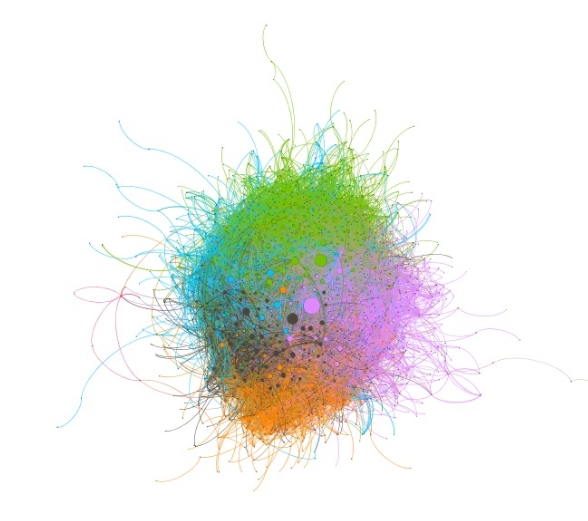

In [6]:
from IPython.display import Image
Image(filename=os.path.join('plots','viz.png'), width=1000, height=1000)

## Triangulos Restaurantes Preferidos

¿Por qué buscamos triángulos dentro de nuestro grafo?:

Los triángulos en una red son de importancia debido a que nos permiten comprender patrones de conectividad, detección de comunidades, el flujo de la información y dar recomendaciones. 

* Agrupamiento y conectividad: los triángulos denotan una fuerte conectividad y agrupamiento dentro de la red, por lo que al haber tres nodos conectados, podemos estar frente a una fuerte interconexión entre estos nodos, permitiendonos identificar grupos o comunidades dentro de la red, tendiendo estos nodos a tener más conexiones entre sí que con nodos que se encuentran fuera del grupo
* Transitividad: a través de este principio podemos ver que si el triángulo esta formado por los nodos A,B y C, donde A está conectado con B y B está conectado con C, existe una alta probabilidad de que A y C también se encuentren conectados, formando así un triángulo
* Inferencia y recomendaciones: los triángulos se pueden usar para realizar inferencia y dar recomendaciones

Probamos cuantos Restaurantes estan en un Triangulo con nuestros preferidos:
- Sarkis
- Kansas
- Don Julio

In [7]:
# Escribo una funcion para revisar que restaurants estan en un triangulo con mi Restaurant preferido Sarkis.
from itertools import combinations
def nodes_in_triangle(G, n):

    triangle_nodes = set([n])

    # Itero pro sobre todas las posibles combinaciones de realciones triangulares
    for n1, n2 in combinations(G.neighbors(n),2):

        # Reviso si hay un nodo entre n1 y n2
        if G.has_edge(n1,n2):

            # Agrego n1 al set de nodos
            triangle_nodes.add(n1)

            # Agrego n2 al set de nodos
            triangle_nodes.add(n2)

    return triangle_nodes

# Busco el nodo con mi restaurante preferido
sarkis = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Sarkis']

kansas = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Kansas Grill & Bar']

donjulio = [n for n,d in projectionG.nodes(data=True) if d['res_name'] == 'Don Julio']

# Le pido a la funcion que me devuelva aquelos nodos

print('Cantidad de Restaurants en Triangulo con Sarkis',len(nodes_in_triangle(clean_G,sarkis[0])))

print('Cantidad de Restaurants en Triangulo con Kansas',len(nodes_in_triangle(clean_G,kansas[0])))

print('Cantidad de Restaurants en Triangulo con Don Julio',len(nodes_in_triangle(clean_G,donjulio[0])))

Cantidad de Restaurants en Triangulo con Sarkis 585
Cantidad de Restaurants en Triangulo con Kansas 23
Cantidad de Restaurants en Triangulo con Don Julio 187


## Recomendador

En el resultado anterior, podemos encontrar que nuetros restaurants señalados estan fuertemente interconectados, dado que presentan una gran cantidad de restaurantes en triangulo con ellos.

**Estamos en busqueda deconcurrir a nuevos restaurantes, pero no sabemos donde ir**

Asi que aprovechando nuestra red construida vamos a generar un recomendador para cada uno de los restaurantes.

## Node2Vec

Con el objetivo de introducir informacion de nodos en un algoritmo de machine learning para poder recomendar, planteamos la idea de utilizar Node2vec.

Node2vec tiene el siguiente funcionamiento:

- A partir de un grafo simulo viajes a traves de los nodos, aproximadamente entre 32 y 64 veces es lo recomendable y de largo 40.

- **Estrategia de sampleo:** Estos viajes uno los puede tomar como un corpus de oraciones, en donde voy a tener una sucesion de nodos en los cuales me voy moviendo en cada paso dado en cada viaje.

- **Skip-gram model:** Una vez hecho esto utiliza un word2vec para generar el embedding

- Busco la similaridad entre los nodos con la similaridad coseno entre los embeddings.

Basado en esto busco generar Recomendaciones de restaurantes basado en Embeddings generados en funcion de la red para los Restaurantes mencionados previamente y con el agregado de Guerrin

In [8]:
import community
#import pacmap
res_pr = nx.pagerank(clean_G)
res_pr = sorted([e for e in res_pr.items()], key=lambda x: x[1], reverse=True)

RETRAIN_RES = False

if RETRAIN_RES:

    res_vectors = Node2Vec(clean_G, dimensions=32, walk_length=40, num_walks=64, workers=4)

    res_model = res_vectors.fit(window=2, min_count=1, negative=10)

    vocabulary = list(res_model.wv.index_to_key)
    X = res_model.wv.get_normed_vectors()

    res_model.save("restaurants_n2v.model")

    embedding = pacmap.PaCMAP(
        n_dims=2,
        n_neighbors=None,
        MN_ratio=0.5,
        FP_ratio=2.0
    ).fit_transform(X)

    with open("res_embedding.p", "wb") as f:
        pickle.dump((X, vocabulary, embedding ), f)

else:

    res_model = gensim.models.Word2Vec.load(os.path.join("models","restaurants_n2v.model"))

    with open(os.path.join("models","res_embedding.p"), "rb") as f:
        X, vocabulary, embedding = pickle.load(f)

print('Similares a Guerrin: ',res_model.wv.most_similar('/restaurantes/Guerrin-499', topn=5),'\n')
print('Similares a Kansas: ',res_model.wv.most_similar('/restaurantes/Kansas-American-Cuisine-1182', topn=5),'\n')
print('Similares a Sarkis: ',res_model.wv.most_similar('/restaurantes/Sarkis-48', topn=5),'\n')
print('Similares a Don Julio: ',res_model.wv.most_similar('/restaurantes/Don-Julio-802', topn=5),'\n')

Similares a Guerrin:  [('/restaurantes/Cafe-Tortoni-1377', 0.8951521515846252), ('/restaurantes/La-Continental-1957', 0.8806291222572327), ('/restaurantes/Campo-dei-Fiori-2239', 0.8800485134124756), ('/restaurantes/La-Nueva-Calesita-2648', 0.8795108795166016), ('/restaurantes/El-Molino-Dorado-8562', 0.8744094967842102)] 

Similares a Kansas:  [('/restaurantes/Melo-2135', 0.9037309288978577), ('/restaurantes/Azul-Profundo-557', 0.9024205207824707), ('/restaurantes/Como-en-Casa-2230', 0.9000488519668579), ('/restaurantes/Kentucky-1858', 0.8959578275680542), ('/restaurantes/Cangas-del-Narcea-363', 0.8886750340461731)] 

Similares a Sarkis:  [('/restaurantes/Bangalore-2740', 0.9368208050727844), ('/restaurantes/La-Dorita-Botanico-6322', 0.9297439455986023), ('/restaurantes/Sullivans-Irish-Pub-Restaurant-1123', 0.9285507798194885), ('/restaurantes/Romario-3361', 0.9266986846923828), ('/restaurantes/Isabel-7784', 0.9226678609848022)] 

Similares a Don Julio:  [('/restaurantes/Elebar-3564', 0

## Embeddings y su representacion

- En el primer plot podemos intentar de representar las primeras 2 dimensiones del embedding coloreado segun la clase utilizando el algoritmo de louvain, se puede distinguir alguna comunidad en funcion de los colores pero no es visible 100%.

- En el segundo plot tenemos los nodos y sus ejes representados con las mismas particiones como color, es aun mas dificil distinguir las comunidades que utilzando solo dos dimensiones del embedding.

C:\Users\Alan\AppData\Local\Temp\ipykernel_14316\4231100821.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis', max(partition.values()) + 1)


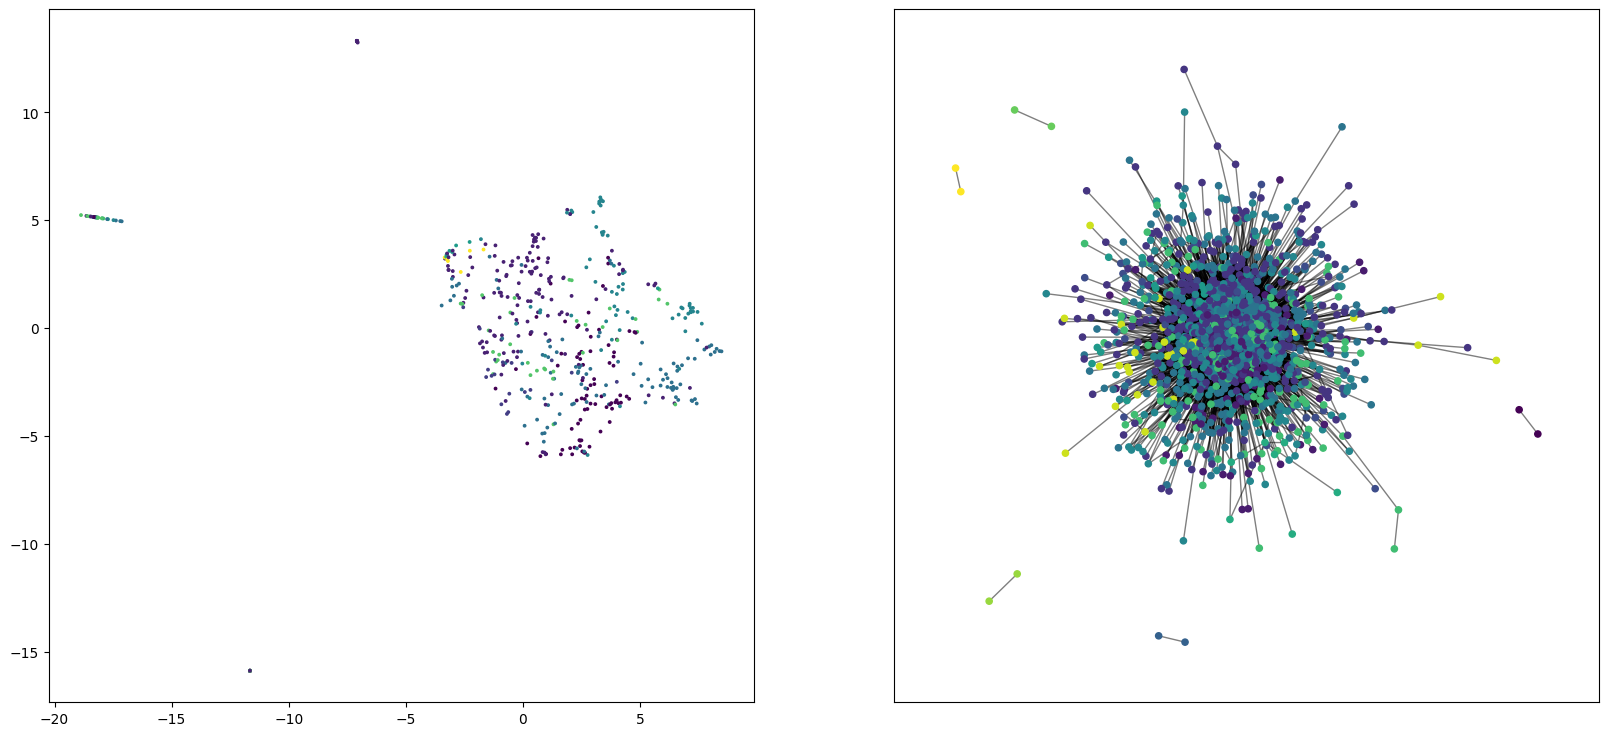

In [11]:
import matplotlib as mpl

partition = community.best_partition(clean_G, weight='weight')

fig, ax = plt.subplots(ncols = 2, figsize=(20,9))

ax[0].scatter(embedding[:, 0],
            embedding[:, 1],
            s=3,
            c = [partition[n] for n in vocabulary])

pos = nx.spring_layout(clean_G,k=0.12,seed=42)
cmap = mpl.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(clean_G, pos, partition.keys(), node_size=20,cmap=cmap, node_color=list(partition.values()),ax=ax[1])
nx.draw_networkx_edges(clean_G, pos, alpha=0.5,ax=ax[1])

plt.show()